In [1]:
# Importing the libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing the dataset
dataset = pd.read_csv('dataset/ads_conversion_rate.csv')

In [3]:
print('Total records:', len(dataset))
print('Total variables:', len(dataset.columns))
print('Percentage of null in each column:')
round(dataset.isnull().sum()/len(dataset)*100,2)

Total records: 10000
Total variables: 10
Percentage of null in each column:


Ad 1     0.0
Ad 2     0.0
Ad 3     0.0
Ad 4     0.0
Ad 5     0.0
Ad 6     0.0
Ad 7     0.0
Ad 8     0.0
Ad 9     0.0
Ad 10    0.0
dtype: float64

In [4]:
dataset.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,0.232,0.359,0.054,0.048,0.056,0.095,0.113,0.316,0.172,0.030
1,0.007,0.030,0.005,0.112,0.050,0.223,0.117,0.129,0.216,0.026
2,0.248,0.324,0.236,0.200,0.112,0.241,0.062,0.017,0.162,0.193
3,0.027,0.447,0.166,0.198,0.132,0.020,0.006,0.111,0.245,0.130
4,0.131,0.296,0.194,0.199,0.116,0.094,0.195,0.342,0.074,0.179


In [5]:
# Which advertisement offers the highest reward?

df_reward = pd.DataFrame(dataset.sum(axis=0, skipna = True)).reset_index().rename(columns={'index':'advertisment',
                                                                                           0:'sum'})

In [6]:
df_reward

,advertisment,sum
0,Ad 1,1240.118
1,Ad 2,2518.145
2,Ad 3,1254.990
3,Ad 4,1252.147
4,Ad 5,1006.300
5,Ad 6,1239.085
6,Ad 7,1256.138
7,Ad 8,1749.628
8,Ad 9,1254.257
9,Ad 10,1253.164


In [7]:
highest_ind = df_reward['sum'].argmax()
highest_ad = df_reward.loc[highest_ind, 'advertisment']
highest_reward = df_reward.loc[highest_ind, 'sum']

print(f'{highest_ad} has highest reward with total click through of {highest_reward}.')

Ad 2 has highest reward with total click through of 2518.144999999987.


## Preliminary Function for Visualization

In [8]:
### Functions for visualization

def get_freq_every_1000(ads_selected_list):
    
    d = {}
    num_choice = len(np.unique(ads_selected_list))

    for i in range(1, 9002, 1000):

        d[i] = pd.DataFrame(pd.Series(ads_selected_list).iloc[i:i+999].value_counts(normalize=True))\
                    .reset_index().rename(columns={0:f'{i}'})

    df_result = pd.merge(d[1], d[1001], on='index', how='left')

    for i in range(2001, 10001, 1000):
        df_result = pd.merge(df_result, d[i], on='index', how='left')

    df_result['ad_selected'] = df_result['index']+1
    
    df_result.fillna(0, inplace=True)

    df_result.sort_values('9001', ascending=False)

    # change format of df for visualization
    df_result_viz = df_result.T.reset_index()

    new_header = df_result_viz.iloc[-1]
    df_result_viz = df_result_viz[1:-1]
    df_result_viz.columns = new_header

    df_result_viz = df_result_viz.rename(columns={'ad_selected':'period'})
    
    ad_list = list(range(1,num_choice+1))
    
    highest_ad_selected = np.argmax(df_result_viz[ad_list].mean())+1
    
    ad_list.remove(highest_ad_selected)
    
    df_average = pd.DataFrame(df_result_viz[ad_list].mean(axis=1)).reset_index().rename(columns={0:'average'})

    df_result_viz = pd.merge(df_result_viz, df_average, left_index=True, right_on='index')
    
    return df_result, df_result_viz

def visualize(df):
    
    sns.set(font_scale = 1.5)
    sns.set_style('white')

    plt.figure(figsize=(13,8))


    for i in range(1,11):

        sns.lineplot(x='period', y=i, data=df, linewidth = 2, color='lightgrey' , sort=False)

    sns.lineplot(x='period', y=2, data=df, linewidth = 2, label=f'Ad 2', sort=False)
    sns.lineplot(x='period', y='average', data=df, linewidth = 2, color='saddlebrown', 
                 label='Average of other Ads', sort=False)

    plt.xlabel('Period', fontsize=18)
    plt.ylabel('Probability', fontsize=18)
    plt.title('Probability of each Ad get selected along the Period', fontsize=21)

    plt.show()

## Strategy 1: Random Selection

In [9]:
import random

def random_select(data, num_choice, num_of_data):

    random.seed(1)

    ads_selected = []
    total_reward = 0
    for n in range(0, num_of_data):
        ad = random.randrange(num_choice)
        ads_selected.append(ad)
        reward = data.values[n, ad]
        total_reward = total_reward + reward

    return ads_selected, total_reward

In [10]:
NUM_CHOICE = 10
DATA_SIZE = 10000

rs_ads_selected, rs_total_reward = random_select(data=dataset, num_choice=NUM_CHOICE, num_of_data=DATA_SIZE)

print(rs_total_reward)

1396.064000000003


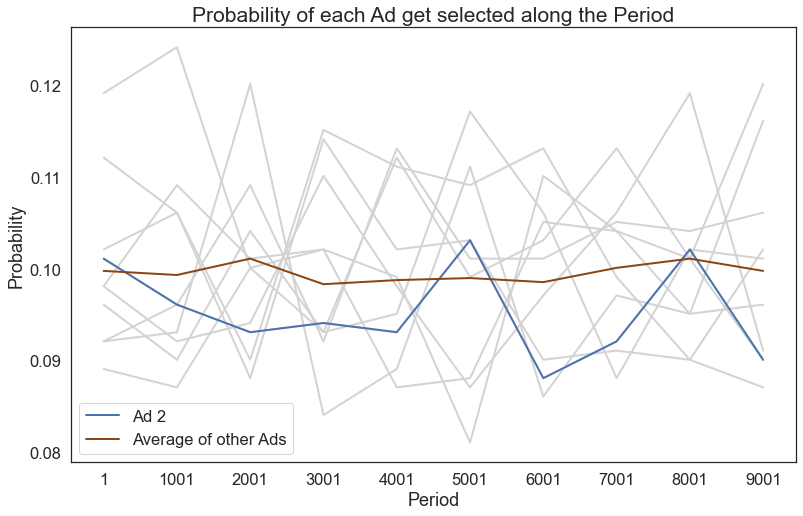

In [11]:
rs_df_result, rs_df_result_viz = get_freq_every_1000(rs_ads_selected)

visualize(rs_df_result_viz)

<b>Conclusion</b>

An advertisement is randomly selected each time.

## Strategy 2: Epsilon-Greedy

Epsilon controls the trade-off between exploitation and exploration. In Epsilon-Greedy, the epsilon is a hyperparameter that greatly affects the performance.


If the randomly generated probability is less than epsilon, MAB will randomly select an advertisement and gather the reward received from showing that advertisement. 

On the other hand, if the randomly generated probability is greater than epsilon, MAB will show the advertisement that has highest reward so far.

Notice that if epsilon=1, it is similar to A/B testing where the algorithm always in the exploration process. 

In [12]:
def ep_policy(data, num_choice, num_of_data, eps=0.15):
    
    ads_selected = []
    numbers_of_selections = [0] * num_choice
    sums_of_reward = [0] * num_choice
    total_reward = 0
    
    np.random.seed(0)

    # loop for whole dataset
    for n in range(0, num_of_data): 
        
        # must randomly choose any ad it it is the first row
        if n==0:
            
            ad = np.random.choice(10) 
            
        else:
        
            prob = np.random.random()

            if prob < eps: 
                
                # randomly choose an advertisement
                ad = np.random.choice(10) 
            else: 
                
                # choose the advertisement that return highest reward so far
                ad = np.argmax([reward/freq if freq!=0 else 0 
                                for reward, freq in zip(sums_of_reward, numbers_of_selections)])

        ads_selected.append(ad)
        numbers_of_selections[ad] += 1
        reward = data.values[n, ad]
        sums_of_reward[ad] += reward
        total_reward += reward

    return ads_selected, numbers_of_selections, sums_of_reward, total_reward

In [13]:
NUM_CHOICE = 10
DATA_SIZE = 10000
EPSILONS = [0.15, 0.3, 0.45]

for EPS in EPSILONS:

    ads_selected, numbers_of_selections, sums_of_reward, total_reward = ep_policy(data=dataset, 
                                                                                  num_choice=NUM_CHOICE, 
                                                                                  num_of_data=DATA_SIZE,
                                                                                  eps=EPS)

    print(f'epsilon={EPS}, total reward={total_reward}')

epsilon=0.15, total reward=2353.6859999999965
epsilon=0.3, total reward=2166.492999999997
epsilon=0.45, total reward=1991.4370000000013


<b>Observation</b>

In this case, EPS=0.15 has the highest reward. Hence, it is chosen as the final representation in Epsilon-Greedy Algorithm.

In [14]:
NUM_CHOICE = 10
DATA_SIZE = 10000
EPS = 0.15

eg_ads_selected, eg_numbers_of_selections, eg_sums_of_reward, eg_total_reward = ep_policy(data=dataset, 
                                                                                          num_choice=NUM_CHOICE, 
                                                                                          num_of_data=DATA_SIZE,
                                                                                          eps=EPS)

print(eg_total_reward)


2353.6859999999965


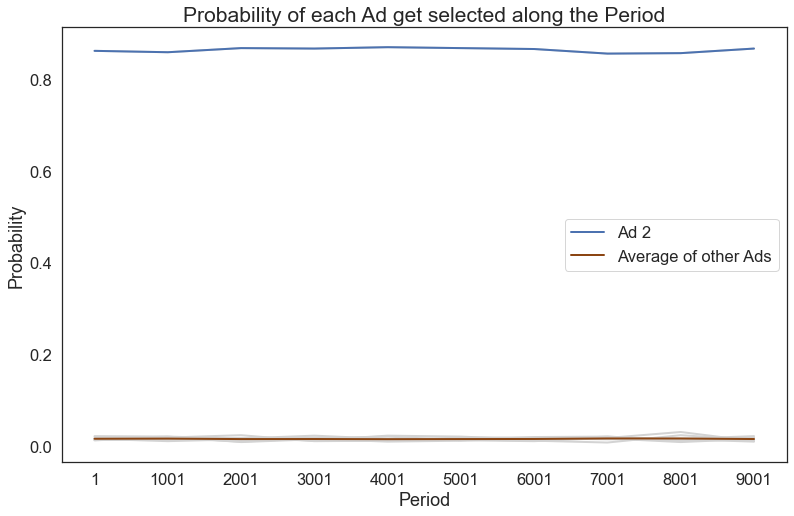

In [15]:
eg_df_result, eg_df_result_viz = get_freq_every_1000(eg_ads_selected)

visualize(eg_df_result_viz)

<b>Conclusion</b>

From the begining, Epsilon Greedy Policy has already favouring Ad 2 which happens to be the optimal ad, and gets the maximum return for the given problem.

This is because when EPS=0.15, there is around 85% chance that the policy will perform exploitation.

## Strategy 3: Decaying Epsilon-Greedy

In this strategy, the epsilon will keep reducing as time passes, to the point where we starting exploring less and less as we becoming more confident of the optimal action.

In [16]:
import math

def dep_policy(data, num_choice, num_of_data):
    
    eps_values = []
    prob_values = []
    
    eps = 1
    eps_min = 0.01
    eps_decay = 0.0005 
    
    ads_selected = []
    numbers_of_selections = [0] * num_choice
    sums_of_reward = [0] * num_choice
    total_reward = 0
    
    np.random.seed(0)

    # loop for whole dataset
    for n in range(0, num_of_data): 
        
        # must randomly choose any ad it it is the first row
        if n==0:
            
            ad = np.random.choice(10) 
            
        else:
        
            if eps > eps_min:
                eps *= (1-eps_decay)
        
            prob = np.random.random()
            
            eps_values.append(eps)
            prob_values.append(prob)

            if prob < eps: 
                ad = np.random.choice(10) 
            else: 
                ad = np.argmax([reward/freq if freq!=0 else 0 
                                for reward, freq in zip(sums_of_reward, numbers_of_selections)])

        ads_selected.append(ad)
        numbers_of_selections[ad] += 1
        reward = data.values[n, ad]
        sums_of_reward[ad] += reward
        total_reward += reward
        
        df_eps_info = pd.DataFrame(list(zip(eps_values, prob_values)), 
                          columns =['eps', 'prob']) 
        
        df_eps_info['time'] = df_eps_info.index+1

    return df_eps_info, ads_selected, numbers_of_selections, sums_of_reward, total_reward

In [17]:
NUM_CHOICE = 10
DATA_SIZE = 10000

deg_eps_info, deg_ads_selected, deg_numbers_of_selections, deg_sums_of_reward, deg_total_reward = dep_policy(data=dataset, 
                                                                                                             num_choice=NUM_CHOICE, 
                                                                                                             num_of_data=DATA_SIZE)

print(deg_total_reward)


2289.626999999996


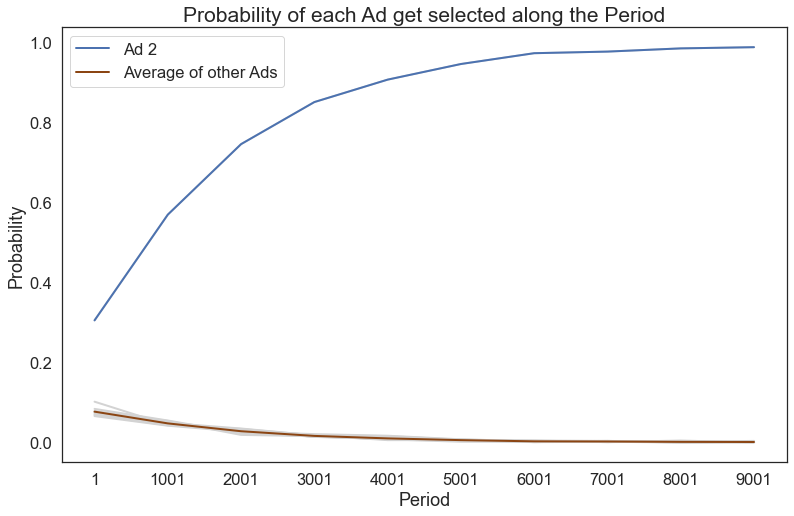

In [18]:
deg_df_result, deg_df_result_viz = get_freq_every_1000(deg_ads_selected)

visualize(deg_df_result_viz)

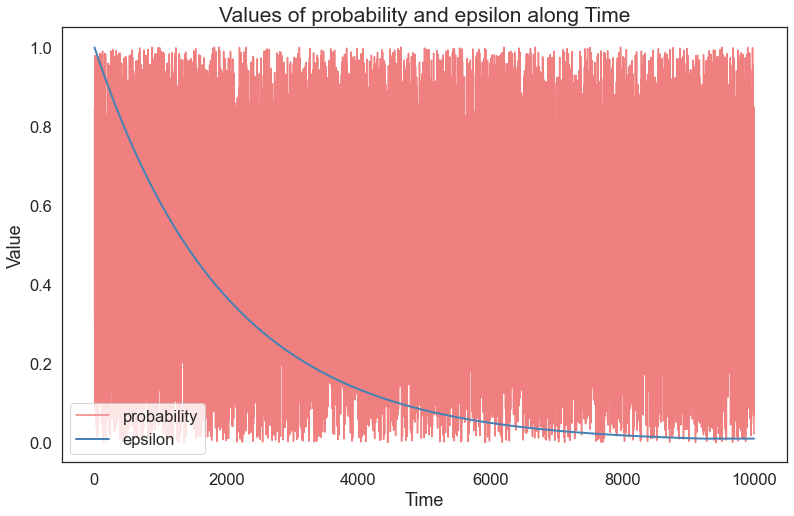

In [19]:
sns.set(font_scale = 1.5)
sns.set_style('white')

plt.figure(figsize=(13,8))

deg_eps_info = deg_eps_info[1:]

sns.lineplot(x='time', y='prob', data=deg_eps_info, color='lightcoral', label='probability', sort=False)
sns.lineplot(x='time', y='eps', data=deg_eps_info, linewidth = 2, color='steelblue', label='epsilon', sort=False)

plt.xlabel('Time', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.title('Values of probability and epsilon along Time', fontsize=21)

plt.show()

<b>Conclusion</b>

In decaying Epsilon-Greedy, the exploitation is gradually increased and this actually ensures all other advertisments have been explored properly.

## Strategy 4: Upper Confidence Bound 1


UCB1 takes confidence term into consideration when selecting the advertisement with highest reward.

For example, the confidence term of advertisement A is increased each time advertisement A is being selected. However, the increment of confidence term will be smaller over time. 

This provides the bahavior where all actions could have almost similar chance to be selected at the begining. However, as the time passes, with the effect of confidence term is getting smaller, MAB should ultimately always select the optimal advertisement.


In [20]:
import math

def ucb1_policy(data, num_choice, num_of_data):
    
    ads_selected = []
    numbers_of_selections = [0] * num_choice
    sums_of_reward = [0] * num_choice
    total_reward = 0

    # loop for whole dataset
    for n in range(0, num_of_data): 

        ad = 0

        max_upper_bound = 0

        for i in range(0, num_choice):

            if (numbers_of_selections[i] > 0):

                average_reward = sums_of_reward[i] / numbers_of_selections[i]
                confidence = math.sqrt(2 * math.log(n+1) / numbers_of_selections[i])
                upper_bound = average_reward + confidence
                
            else:

                upper_bound = 1e400

            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound

                ad = i

        ads_selected.append(ad)
        numbers_of_selections[ad] += 1
        reward = data.values[n, ad]
        sums_of_reward[ad] += reward
        total_reward += reward

    return ads_selected, numbers_of_selections, sums_of_reward, total_reward

In [21]:
NUM_CHOICE = 10
DATA_SIZE = 10000

ucb_ads_selected, ucb_numbers_of_selections, ucb_sums_of_reward, ucb_total_reward = ucb1_policy(data=dataset, 
                                                                                                num_choice=NUM_CHOICE, 
                                                                                                num_of_data=DATA_SIZE)

print(ucb_total_reward)

1930.6460000000045


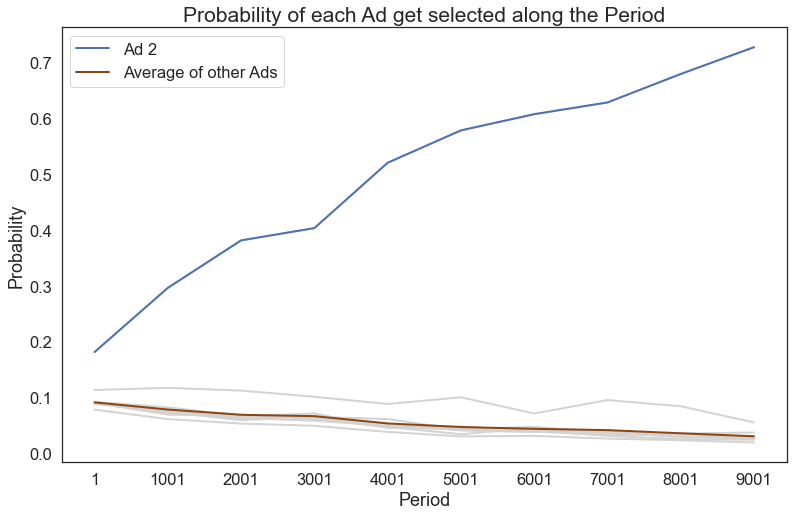

In [22]:
ucb_df_result, ucb_df_result_viz = get_freq_every_1000(ucb_ads_selected)

visualize(ucb_df_result_viz)

<b>Conclusion</b>

With just less than 1000 trials, UCB1 has already favouring Ad 2 which happens to be the optimal ad.

## Strategy 5: Bayesian Upper Confidence Bound

Bayesian UCB is the extension of UCB1 that incorporating prior information about the distribution of rewards from different advertisements to allow more efficient exploration.

In [23]:
from collections import defaultdict 

import math

def bucb_policy(data, num_choice, num_of_data, ucb_scale=1.96):
    
    ads_selected = []
    numbers_of_selections = [0] * num_choice
    sums_of_reward = [0] * num_choice
    total_reward = 0
    
    dict_selections = defaultdict(list)

    # loop for whole dataset
    for n in range(0, num_of_data): 

        ad = 0

        max_upper_bound = 0
        
        for i in range(0, num_choice):
            
            # perform ucb1 if it is less than 500 rows to collect info
            if (n<=500) & (numbers_of_selections[i] > 0):
                
                average_reward = sums_of_reward[i] / numbers_of_selections[i]
                delta_i = math.sqrt(2 * math.log(n+1) / numbers_of_selections[i])
                upper_bound = average_reward + delta_i

            elif (n>500) & (numbers_of_selections[i] > 0):

                average_reward = sums_of_reward[i] / numbers_of_selections[i]
                
                variance_reward = sum([((x - average_reward) ** 2) for x in dict_selections[i]]) / len(dict_selections[i]) 
                std_reward = variance_reward ** 0.5
                delta_i = ucb_scale*std_reward/np.sqrt(numbers_of_selections[i])
                
                upper_bound = average_reward + delta_i
                
            else:

                upper_bound = 1e400

            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound

                ad = i

        ads_selected.append(ad)
        numbers_of_selections[ad] += 1
        reward = data.values[n, ad]
        dict_selections[ad].append(reward)
        sums_of_reward[ad] += reward
        total_reward += reward
        
    return ads_selected, numbers_of_selections, sums_of_reward, total_reward

In [24]:
NUM_CHOICE = 10
DATA_SIZE = 10000

bucb_ads_selected, bucb_numbers_of_selections, bucb_sums_of_reward, bucb_total_reward = bucb_policy(data=dataset, 
                                                                                                    num_choice=NUM_CHOICE, 
                                                                                                    num_of_data=DATA_SIZE)

print(bucb_total_reward)

2460.90199999999


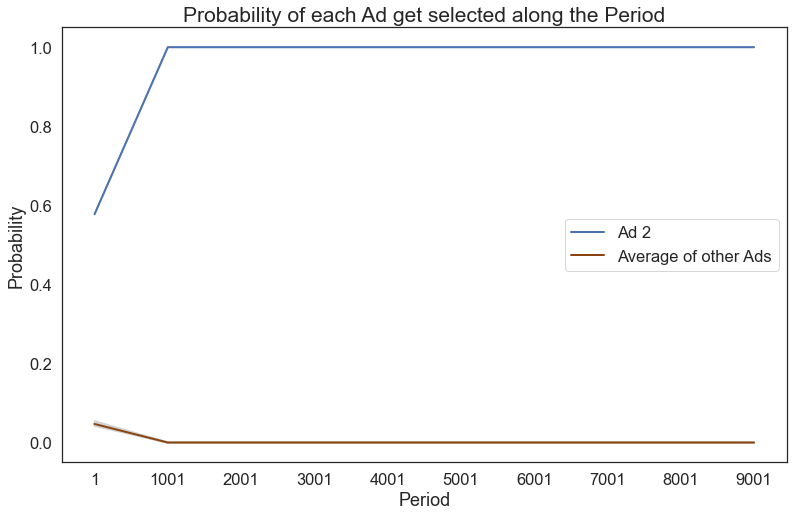

In [25]:
bucb_df_result, bucb_df_result_viz = get_freq_every_1000(bucb_ads_selected)

visualize(bucb_df_result_viz)

<b>Conclusion</b>

After 1000 trials, Bayesian UCB has always allocating Ad 2 and gets the maximum return.

---

### Reference:

https://www.analyticsvidhya.com/blog/2018/09/reinforcement-multi-armed-bandit-scratch-python/